In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib
import os

# 1. Cargar datos
df = pd.read_csv('../data/processed/dataset_clasificacion.csv')
X = df[['danceability', 'energy', 'valence', 'tempo']]
y = df['popularity_class']

In [2]:
# 2. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [3]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)


In [4]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


grid_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train_res, y_train_res)

print("Mejores parámetros RF:", grid_rf.best_params_)
y_pred_rf = grid_rf.predict(X_test)
print("RF Report:\n", classification_report(y_test, y_pred_rf))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejores parámetros RF: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
RF Report:
               precision    recall  f1-score   support

        alta       0.59      0.76      0.66      4401
        baja       0.68      0.71      0.69     59716
       media       0.48      0.43      0.45     35494

    accuracy                           0.61     99611
   macro avg       0.58      0.63      0.60     99611
weighted avg       0.60      0.61      0.61     99611



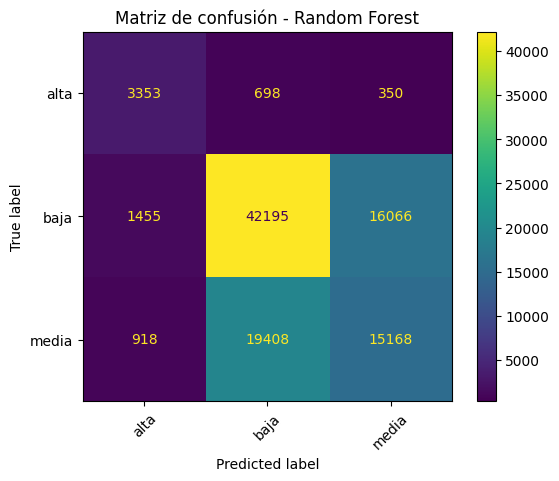

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf, labels=grid_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_rf.classes_)
disp.plot(xticks_rotation=45)
plt.title("Matriz de confusión - Random Forest")
plt.show()


In [8]:
# Crear carpeta 'models' si no existe
os.makedirs("models", exist_ok=True)

# Guardar el mejor estimador de GridSearchCV
joblib.dump(grid_rf.best_estimator_, "models/random_forest_model.pkl")

['models/random_forest_model.pkl']